# Analysis of Customer Purchase Behaviour

In today's competitive business, it is vital to understand the long-term value of a customer. 
Customer Lifetime Value (CLTV) is a metric that represents the total amount of money a customer is expected to spend in your business or your products during their lifetime.
It's a crucial measure that helps businesses in strategizing their marketing efforts, resource allocation and product development.

**Overview of RFM Analysis**

RFM(RECENCY, FREQUENCY, MONETARY) Analysis is a marketing technique used for quantifying and evaluating customer behaviour. It segments customers based on their tranaction history - how recently and how often they purchased, and how much they spent.


* **Recency(R):** This is the measure of how recently a customer has made a purchase. A recent purchase is a strong indicator that the customer is active and more likely to buy again.


* **Frequency(F):** This accesses how often a customer makes a purchase. Frequent buyers are more likely to continue purchasing in the future, indicating higher loyalty, satisfaction and engagement. While infrequent purchases suggests a need for re-engagement strategies.


* **Monetary Value(M):** This evaluates how much money a customer has spent over time. Customers who spend more are the valuable. This determines the customer's value to the business. High monetary customers contribute more to revenue, while lower spenders may require targeted strategies to increase their purchasing activity.


To successfully perform RFM, our dataset must have some crucial features:

* **Customer Identifier:** A unique identifier for each customer to differentiate between customers and aggregate purchases on a per-customer basis.

* **Transaction/Purchase Date:** Date and time the purchases were made to calculate the Recency component of RFM.

* **Transaction Value:** The monetary value of each transaction to compute the Monetary component of RFM, which is total amount spent by the customer.

* **Transaction Frequency (Optional):** Information on the frequency of transactions. It can as well be done by counting the number of transactions per customer.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Analysis of Customer Purchase Behavior").getOrCreate()

In [0]:
df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/FileStore/tables/Online_Retail-1.csv")

In [0]:
df.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



## Data Cleaning

In [0]:
from pyspark.sql.functions import col

# Remove rows with null values in critical columns
df = df.filter(col("InvoiceNo").isNotNull() & 
                              col("CustomerID").isNotNull() &
                              col("Quantity").isNotNull() & 
                              col("UnitPrice").isNotNull())

# Drop duplicates
df = df.dropDuplicates()

## Feature Engineering

In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

timeFmt = "MM/d/yy H:mm"
df = df.withColumn('InvoiceDate',
                   to_utc_timestamp(unix_timestamp(col('InvoiceDate'), timeFmt).cast('timestamp'),
                   'UTC'))

In [0]:
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|    

In [0]:
from pyspark.sql.functions import to_timestamp, col, expr

# Add a TotalPrice column
df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# Verify changes
df.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|    

## Calculating RFM Metrics

In [0]:
from pyspark.sql.functions import max, datediff, lit, count, sum

# Set the reference date for Recency
reference_date = lit("2011-12-10")

# Recency: Days since last purchase
recency_df = df.groupBy("CustomerID").agg(
    max("InvoiceDate").alias("LastPurchaseDate")
).withColumn(
    "Recency", datediff(reference_date, col("LastPurchaseDate"))
)

# Frequency: Count of unique invoices
frequency_df = df.groupBy("CustomerID").agg(
    count("InvoiceNo").alias("Frequency")
)

# Monetary: Total spending
monetary_df = df.groupBy("CustomerID").agg(
    sum("TotalPrice").alias("Monetary")
)

# Combine RFM metrics into one DataFrame
rfm_df = recency_df.join(frequency_df, "CustomerID").join(monetary_df, "CustomerID")

# Show RFM DataFrame
rfm_df.show(5)

+----------+-------------------+-------+---------+------------------+
|CustomerID|   LastPurchaseDate|Recency|Frequency|          Monetary|
+----------+-------------------+-------+---------+------------------+
|     15727|2011-11-23 12:36:00|     17|      301|           5159.06|
|     16861|2011-10-11 09:05:00|     60|        8|            151.65|
|     16503|2011-08-25 11:46:00|    107|       86|           1421.43|
|     17389|2011-12-09 09:38:00|      1|      224|31300.079999999998|
|     14450|2011-06-12 10:46:00|    181|       40|            483.25|
+----------+-------------------+-------+---------+------------------+
only showing top 5 rows



In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Calculate quantiles for Recency and Frequency
recency_quantiles = rfm_df.approxQuantile("Recency", [0.2, 0.4, 0.6, 0.8], 0)
frequency_quantiles = rfm_df.approxQuantile("Frequency", [0.2, 0.4, 0.6, 0.8], 0)

# Define a function to assign scores based on quantiles
def assign_score(column, quantiles, reverse=False):
    if reverse:
        # Higher values = Lower scores
        return (
            F.when(col(column) <= quantiles[0], 5)
             .when((col(column) > quantiles[0]) & (col(column) <= quantiles[1]), 4)
             .when((col(column) > quantiles[1]) & (col(column) <= quantiles[2]), 3)
             .when((col(column) > quantiles[2]) & (col(column) <= quantiles[3]), 2)
             .otherwise(1)
        )
    else:
        # Higher values = Higher scores
        return (
            F.when(col(column) <= quantiles[0], 1)
             .when((col(column) > quantiles[0]) & (col(column) <= quantiles[1]), 2)
             .when((col(column) > quantiles[1]) & (col(column) <= quantiles[2]), 3)
             .when((col(column) > quantiles[2]) & (col(column) <= quantiles[3]), 4)
             .otherwise(5)
        )

# Add Recency and Frequency scores to the DataFrame
rfm_df = rfm_df.withColumn("Recency_score", assign_score("Recency", recency_quantiles, reverse=True))
rfm_df = rfm_df.withColumn("Frequency_score", assign_score("Frequency", frequency_quantiles, reverse=False))

# Combine RFM scores into an RFM segment
rfm_df = rfm_df.withColumn(
    "RFM_Segment", 
    F.concat(F.col("Recency_score").cast("string"), 
             F.col("Frequency_score").cast("string"))
)

In [0]:
from pyspark.sql.functions import col, concat

# Combine Recency_score and Frequency_score to create rfm_segment
rfm_df = rfm_df.withColumn(
    "rfm_segment", 
    concat(
        col("Recency_score").cast("string"),
        col("Frequency_score").cast("string")
    )
)

# Verify the results
rfm_df.select("Recency_score", "Frequency_score", "rfm_segment").show(10, truncate=False)

+-------------+---------------+-----------+
|Recency_score|Frequency_score|rfm_segment|
+-------------+---------------+-----------+
|4            |5              |45         |
|3            |1              |31         |
|2            |4              |24         |
|5            |5              |55         |
|1            |3              |13         |
|1            |1              |11         |
|3            |3              |33         |
|4            |4              |44         |
|4            |5              |45         |
|1            |2              |12         |
+-------------+---------------+-----------+
only showing top 10 rows



In [0]:
rfm_df.show(5)

+----------+-------------------+-------+---------+------------------+-------------+---------------+-----------+
|CustomerID|   LastPurchaseDate|Recency|Frequency|          Monetary|Recency_score|Frequency_score|rfm_segment|
+----------+-------------------+-------+---------+------------------+-------------+---------------+-----------+
|     15727|2011-11-23 12:36:00|     17|      301|           5159.06|            4|              5|         45|
|     16861|2011-10-11 09:05:00|     60|        8|            151.65|            3|              1|         31|
|     16503|2011-08-25 11:46:00|    107|       86|           1421.43|            2|              4|         24|
|     17389|2011-12-09 09:38:00|      1|      224|31300.079999999998|            5|              5|         55|
|     14450|2011-06-12 10:46:00|    181|       40|            483.25|            1|              3|         13|
+----------+-------------------+-------+---------+------------------+-------------+---------------+-----

## Data Visualization

Recency Distribution

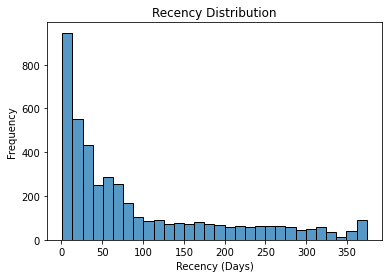

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

# Convert the Spark DataFrame to Pandas
rfm_pd = rfm_df.select("Recency").toPandas()

# Plot Recency Distribution
sns.histplot(data=rfm_pd, x="Recency", bins=30)
plt.title("Recency Distribution")
plt.xlabel("Recency (Days)")
plt.ylabel("Frequency")
plt.show()


Frequency Distribution

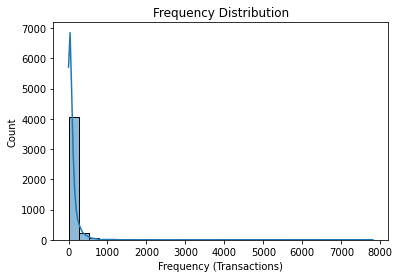

In [0]:
# Convert the Spark DataFrame to Pandas
rfm_pd = rfm_df.select("Frequency").toPandas()

# Plot Frequency Distribution
sns.histplot(data=rfm_pd, x="Frequency", bins=30, kde=True)
plt.title("Frequency Distribution")
plt.xlabel("Frequency (Transactions)")
plt.ylabel("Count")
plt.show()

Monetary Distribution

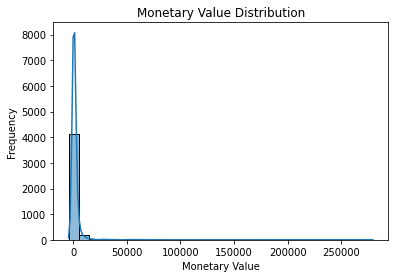

In [0]:
# Convert the Spark DataFrame to Pandas
rfm_pd = rfm_df.select("Monetary").toPandas()

# Plot Monetary Value Distribution
sns.histplot(data=rfm_pd, x="Monetary", bins=30, kde=True)
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.show()

## Customer Segmentation

In [0]:
from pyspark.sql.functions import when, col

# Define segment mapping logic
rfm_df = rfm_df.withColumn(
    "Customer_Segment",
    when(col("rfm_segment").rlike(r'[1-2][1-2]'), 'Hibernating')
    .when(col("rfm_segment").rlike(r'[1-2][3-4]'), 'At-Risk')
    .when(col("rfm_segment").rlike(r'[1-2]5'), "Can't Lose")
    .when(col("rfm_segment").rlike(r'3[1-2]'), 'About to Slip')
    .when(col("rfm_segment").rlike(r'33'), 'Need Attention')
    .when(col("rfm_segment").rlike(r'[3-4][4-5]'), 'Loyal Customers')
    .when(col("rfm_segment").rlike(r'41'), 'Promising')
    .when(col("rfm_segment").rlike(r'51'), 'New Customers')
    .when(col("rfm_segment").rlike(r'[4-5][2-3]'), 'Potential Loyalists')
    .when(col("rfm_segment").rlike(r'5[4-5]'), 'Champions')
    .otherwise('Unknown')  # Default case for unmatched patterns
)

# Verify the mapping
rfm_df.select("rfm_segment", "Customer_Segment").show(10, truncate=False)


+-----------+----------------+
|rfm_segment|Customer_Segment|
+-----------+----------------+
|45         |Loyal Customers |
|31         |About to Slip   |
|24         |At-Risk         |
|55         |Champions       |
|13         |At-Risk         |
|11         |Hibernating     |
|33         |Need Attention  |
|44         |Loyal Customers |
|45         |Loyal Customers |
|12         |Hibernating     |
+-----------+----------------+
only showing top 10 rows



In [0]:
rfm_df.show(5)

+----------+-------------------+-------+---------+------------------+-------------+---------------+-----------+----------------+
|CustomerID|   LastPurchaseDate|Recency|Frequency|          Monetary|Recency_score|Frequency_score|rfm_segment|Customer_Segment|
+----------+-------------------+-------+---------+------------------+-------------+---------------+-----------+----------------+
|     15727|2011-11-23 12:36:00|     17|      301|           5159.06|            4|              5|         45| Loyal Customers|
|     16861|2011-10-11 09:05:00|     60|        8|            151.65|            3|              1|         31|   About to Slip|
|     16503|2011-08-25 11:46:00|    107|       86|           1421.43|            2|              4|         24|         At-Risk|
|     17389|2011-12-09 09:38:00|      1|      224|31300.079999999998|            5|              5|         55|       Champions|
|     14450|2011-06-12 10:46:00|    181|       40|            483.25|            1|              

In [0]:
new_rfm = rfm_df[["Recency", "Frequency", "Monetary", "Customer_Segment"]]
new_rfm.show(5)

+-------+---------+------------------+----------------+
|Recency|Frequency|          Monetary|Customer_Segment|
+-------+---------+------------------+----------------+
|     17|      301|           5159.06| Loyal Customers|
|     60|        8|            151.65|   About to Slip|
|    107|       86|           1421.43|         At-Risk|
|      1|      224|31300.079999999998|       Champions|
|    181|       40|            483.25|         At-Risk|
+-------+---------+------------------+----------------+
only showing top 5 rows



In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Add a monotonically increasing index (this gives a unique ID, but not sequential)
new_rfm = new_rfm.withColumn("index", F.monotonically_increasing_id())

# Alternatively, to get sequential row numbers:
window_spec = Window.orderBy(F.lit(1))  # To get row number for the entire DataFrame
new_rfm = new_rfm.withColumn("index", F.row_number().over(window_spec))

# Cast the index column to integer
new_rfm = new_rfm.withColumn("index", new_rfm["index"].cast("int"))

# Show the result
new_rfm.show()

+-------+---------+------------------+-------------------+-----+
|Recency|Frequency|          Monetary|   Customer_Segment|index|
+-------+---------+------------------+-------------------+-----+
|     17|      301|           5159.06|    Loyal Customers|    1|
|     60|        8|            151.65|      About to Slip|    2|
|    107|       86|           1421.43|            At-Risk|    3|
|      1|      224|31300.079999999998|          Champions|    4|
|    181|       40|            483.25|            At-Risk|    5|
|    331|        9|155.17000000000002|        Hibernating|    6|
|     51|       30|            598.83|     Need Attention|    7|
|     31|       83|             652.4|    Loyal Customers|    8|
|     24|      187|           2709.12|    Loyal Customers|    9|
|    281|       29|218.06000000000003|        Hibernating|   10|
|     29|       81|            302.57|    Loyal Customers|   11|
|    285|       18| 94.04999999999998|        Hibernating|   12|
|    153|       22|236.77

In [0]:
columns_order = ['index', 'Recency', 'Frequency', 'Monetary', 'Customer_Segment']
new_rfm = new_rfm[columns_order]

In [0]:
new_rfm.show(5)

+-----+-------+---------+------------------+----------------+
|index|Recency|Frequency|          Monetary|Customer_Segment|
+-----+-------+---------+------------------+----------------+
|    1|     17|      301|           5159.06| Loyal Customers|
|    2|     60|        8|            151.65|   About to Slip|
|    3|    107|       86|           1421.43|         At-Risk|
|    4|      1|      224|31300.079999999998|       Champions|
|    5|    181|       40|            483.25|         At-Risk|
+-----+-------+---------+------------------+----------------+
only showing top 5 rows



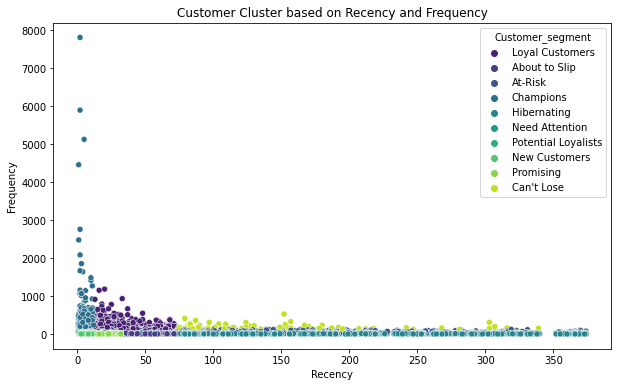

In [0]:
plot_data = new_rfm.select('Recency', 'Frequency', 'Customer_segment').toPandas()

# Create the plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', 
                y='Frequency', 
                hue='Customer_segment', 
                data=plot_data, 
                palette='viridis')

plt.title('Customer Cluster based on Recency and Frequency')
plt.show()

In [0]:
import plotly.express as px

# Get value counts from PySpark DataFrame
segments = new_rfm.groupBy('Customer_segment').count().toPandas()

# Create the bar plot
fig = px.bar(
    segments,
    x='Customer_segment',
    y='count',
    color='Customer_segment',
    text='count',
    title="RFM Segments"
)

# Update layout
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)

fig.show()

## Predictions

Creating a Dummy Target Variable

In [0]:
from pyspark.sql.functions import rand
import pyspark.sql.functions as F

# Select features
features = new_rfm.select('Recency', 'Frequency', 'Monetary')

# Add random FutureSpending column
# Note: rand() * 3000 will generate random numbers between 0 and 3000
rfm = new_rfm.withColumn('FutureSpending', F.rand() * 3000)

In [0]:
# First, combine features and target into one DataFrame
from pyspark.sql.functions import col

# Create feature columns list
feature_cols = ['Recency', 'Frequency', 'Monetary']

# Combine features and target
data = rfm.select(
    *feature_cols,
    col('FutureSpending').alias('label')  # PySpark's ML expects target column to be named 'label'
)

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# If you need separate feature and label DataFrames:
X_train = train_data.select(feature_cols)
y_train = train_data.select('label')
X_test = test_data.select(feature_cols)
y_test = test_data.select('label')

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Create vector assembler to combine feature columns into a single vector column
assembler = VectorAssembler(
    inputCols=['Recency', 'Frequency', 'Monetary'],
    outputCol='features'
)

# Apply vector assembler to training and test data
train_vector = assembler.transform(train_data)
test_vector = assembler.transform(test_data)

# Create and fit the linear regression model
lin_reg = LinearRegression(
    featuresCol='features',
    labelCol='label'
)

model = lin_reg.fit(train_vector)

# Print model coefficients and intercept
print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

Coefficients: [-0.11738852151286659,-0.045506273975535395,0.0009830322442991703]
Intercept: 1500.8315498359937


In [0]:
# Make predictions
predictions = model.transform(test_vector)

# Show predictions alongside actual values
predictions.select('label', 'prediction').show(5)

+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
| 356.5535051547548|1499.8190749143105|
|2006.3730958413898|1498.7775350969966|
|1043.4711020125933|1503.4337715948936|
|2619.0134392232276|1496.7981055468194|
| 2443.330616277112|1494.8030640899956|
+------------------+------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions
predictions = model.transform(test_vector)

# Create evaluator
evaluator = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction'
)

# Calculate MSE
mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'})

# Calculate R²
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# If you also want RMSE:
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 803241.6693843406
R^2 Score: -0.0009757802905019375
Root Mean Squared Error: 896.2375072403189
